In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas seaborn hmmlearn

In [2]:
# Importation of dependencies
import warnings
import itertools
import openmeteo_requests

import matplotlib.pyplot as plt
import requests_cache
import pandas as pd
from retry_requests import retry
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn import metrics
from hmmlearn import hmm
import pickle

from sklearn.model_selection import GridSearchCV

#### Loading district meta data

In [3]:
df_districts = pd.read_csv("RwandaDistrictCentroidsLongitude_Latitude.csv")

In [4]:
districts = dict()
for i in range(len(df_districts)):
    districts[df_districts.loc[i, "District"]] = {
        'province': df_districts.loc[i, "Province"],
        'lat':  -df_districts.loc[i, "Latitude"],
        'long': df_districts.loc[i, "Longitude"]
    }

In [5]:
district_names = ['Gatsibo', 'Muhanga', 'Gicumbi', 'Kicukiro', 'Rulindo', 'Nyaruguru',
       'Rwamagana', 'Kamonyi', 'Gasabo', 'Ngororero', 'Rubavu', 'Nyamagabe',
       'Burera', 'Nyabihu', 'Gakenke', 'Nyamasheke', 'Kirehe', 'Nyagatare',
       'Bugesera', 'Karongi', 'Huye', 'Musanze', 'Rusizi', 'Ngoma',
       'Nyarugenge', 'Gisagara', 'Kayonza', 'Ruhango', 'Nyanza', 'Rutsiro']

#### Downloading Dataset

In [6]:
daily_data = dict()

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)
url = "https://archive-api.open-meteo.com/v1/era5"

for district in districts:
    params = {
    	"latitude": districts[district]['lat'],
    	"longitude":   districts[district]['long'],
        "start_date": "2024-01-01", # Forecast Horizon Starts
        "end_date": "2024-04-20", # Forecast Horizon Ends
    	"daily": "rain_sum"
    }
    responses = openmeteo.weather_api(url, params=params)
    
    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    daily = response.Daily()
    
    daily_data[district] = daily.Variables(0).ValuesAsNumpy()
    
date = pd.date_range(
    	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
    	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
    	freq = pd.Timedelta(seconds = daily.Interval()),
    	inclusive = "left")

validation_data = pd.DataFrame(data = daily_data, index = date)

In [7]:
validation_data

,Gatsibo,Muhanga,Gicumbi,Kicukiro,Rulindo,Nyaruguru,Rwamagana,Kamonyi,Gasabo,Ngororero,...,Huye,Musanze,Rusizi,Ngoma,Nyarugenge,Gisagara,Kayonza,Ruhango,Nyanza,Rutsiro
2024-01-01 00:00:00+00:00,0.900000,0.800000,8.5,2.2,9.799999,0.700000,3.7,1.9,3.3,21.600000,...,2.500000,3.000000,1.5,5.300000,3.600000,11.3,0.4,4.700000,3.800000,26.900002
2024-01-02 00:00:00+00:00,5.900000,7.200000,5.4,1.8,8.700000,29.300001,7.9,6.8,5.4,11.000000,...,10.500002,2.000000,10.7,4.500000,1.400000,1.2,0.8,9.799999,8.400000,17.900000
2024-01-03 00:00:00+00:00,4.400000,1.500000,6.4,0.8,3.700000,23.700001,6.0,0.7,1.7,0.700000,...,2.400000,0.300000,2.0,4.200000,6.200000,8.4,4.5,1.600000,7.800000,8.300000
2024-01-04 00:00:00+00:00,0.600000,0.400000,1.9,0.6,1.100000,11.700001,0.7,5.1,0.2,12.400000,...,4.600000,0.600000,5.5,0.200000,2.100000,7.5,0.0,9.700000,7.500000,16.400002
2024-01-05 00:00:00+00:00,0.000000,0.100000,0.2,0.2,0.400000,2.900000,0.1,0.5,0.2,2.500000,...,2.200000,0.000000,0.8,0.000000,0.200000,0.5,0.8,0.400000,1.600000,12.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16 00:00:00+00:00,0.700000,12.900000,3.0,4.2,3.700000,4.900000,3.4,8.1,4.2,4.500000,...,10.000002,0.100000,1.0,5.400000,9.700001,4.9,0.5,6.100000,13.500001,2.100000
2024-04-17 00:00:00+00:00,2.300000,6.700000,4.0,1.2,5.300000,2.800000,1.5,3.5,3.8,6.699999,...,1.700000,1.000000,2.6,1.600000,1.700000,0.8,0.3,4.600000,3.200000,11.300000
2024-04-18 00:00:00+00:00,3.300000,0.900000,2.9,0.6,1.000000,2.700000,2.9,2.1,2.0,2.500000,...,1.300000,0.700000,7.1,1.800000,2.200000,3.3,1.7,2.200000,1.500000,4.400000
2024-04-19 00:00:00+00:00,1.700000,8.599999,1.2,2.1,2.500000,6.200000,0.7,5.5,1.6,6.300000,...,12.400001,3.000000,7.4,1.400000,4.200000,12.4,1.9,12.000000,5.400000,7.099999


In [297]:
df_rainfall = pd.read_csv('training_data.csv')
df_rainfall['Unnamed: 0'] = pd.to_datetime(df_rainfall['Unnamed: 0'])
df_rainfall.set_index('Unnamed: 0', drop=True, inplace=True) # Making 'Date' the index
df_rainfall.index = pd.DatetimeIndex(df_rainfall.index) # Setting the index

In [291]:
df_rainfall

,Gatsibo,Muhanga,Gicumbi,Kicukiro,Rulindo,Nyaruguru,Rwamagana,Kamonyi,Gasabo,Ngororero,...,Huye,Musanze,Rusizi,Ngoma,Nyarugenge,Gisagara,Kayonza,Ruhango,Nyanza,Rutsiro
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2008-01-01 00:00:00+00:00,0.000000,0.400000,0.200000,0.100000,0.000000,0.100000,0.100000,0.000000,0.000000,0.400000,...,0.400000,0.000000,0.100000,0.0,0.400000,0.000000,0.300000,0.400000,0.400000,0.400000
2008-01-02 00:00:00+00:00,0.000000,0.300000,0.100000,0.300000,0.100000,0.900000,0.300000,0.300000,0.300000,0.500000,...,0.400000,0.100000,0.000000,0.2,0.300000,0.400000,0.200000,0.400000,0.400000,0.500000
2008-01-03 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,...,0.000000,0.000000,0.300000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000
2008-01-04 00:00:00+00:00,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.200000,0.000000,0.000000,0.0,0.200000,0.000000,0.000000,0.200000,0.200000,0.000000
2008-01-05 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.200000,...,0.000000,0.000000,3.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27 00:00:00+00:00,6.099999,14.400001,9.999999,5.600000,16.800001,18.400002,8.500001,14.499999,18.400002,19.200000,...,12.500001,12.200002,31.500000,8.3,11.200001,11.700001,5.100001,25.399998,17.400000,27.200000
2023-12-28 00:00:00+00:00,2.200000,9.800000,3.800000,8.100000,4.700000,6.500000,4.200000,1.900000,4.200000,15.099999,...,14.500000,7.400000,23.500002,8.3,3.100000,6.300000,2.100000,11.400001,13.600000,24.300003
2023-12-29 00:00:00+00:00,0.800000,0.300000,0.700000,1.100000,0.400000,1.000000,1.100000,0.900000,1.200000,0.400000,...,0.200000,0.200000,7.100000,1.0,0.800000,1.900000,0.100000,0.700000,0.700000,0.800000


#### Visualizing the Correlation in Daily Rainfall Sum Across All Districts

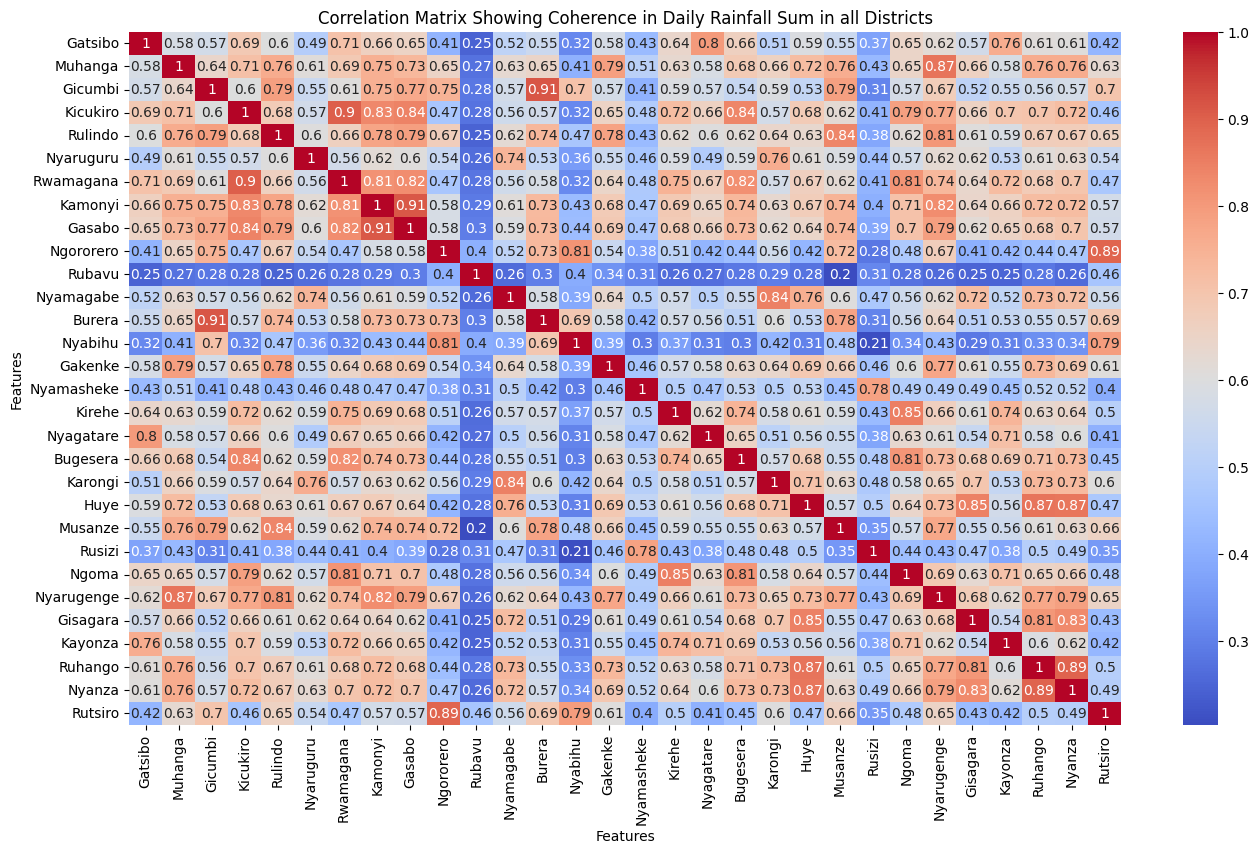

In [10]:
data = df_rainfall.loc[:, district_names]
corr_matrix = data.corr()

# Producing heatmap for the correlation matrix
fig, axs = plt.subplots(1, 1, figsize=(16, 9))
axs.set_title('Correlation Matrix Showing Coherence in Daily Rainfall Sum in all Districts')
sb.heatmap(corr_matrix, cmap='coolwarm', annot=True)

plt.ylabel('Features')
plt.xlabel('Features')
plt.show()

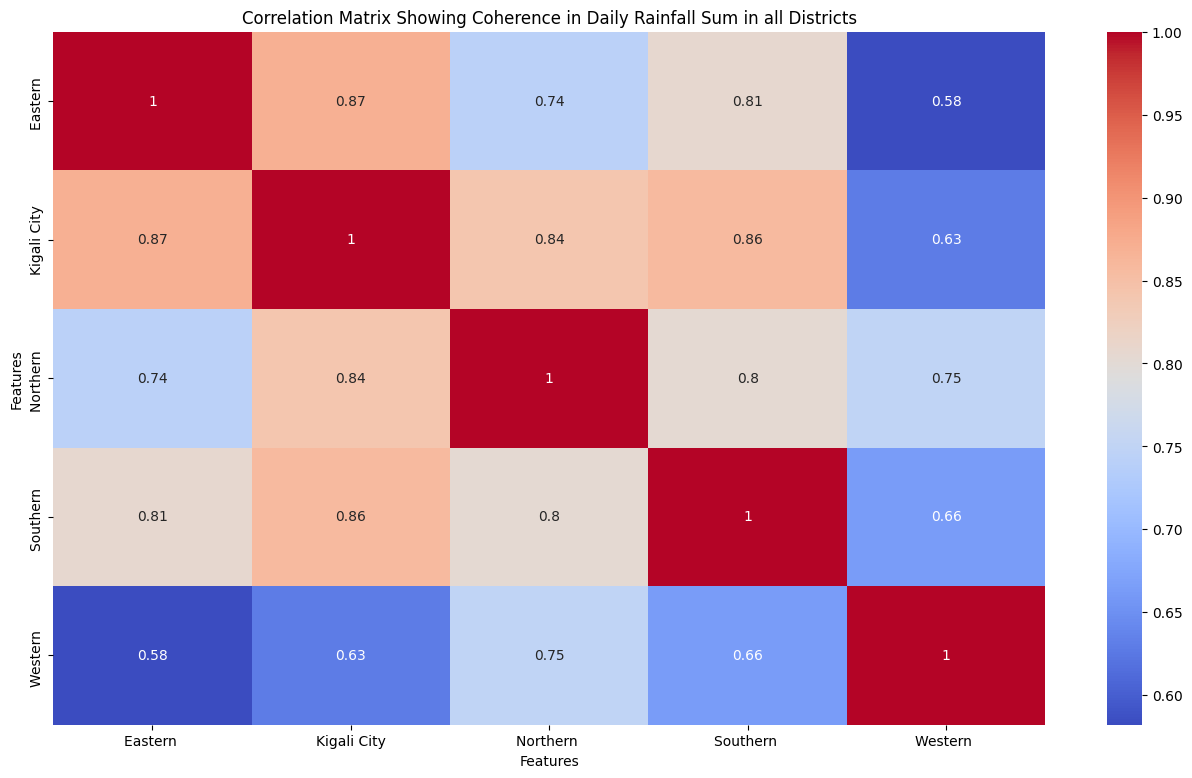

In [11]:
data_transposed = data.T
data_transposed['Provinces'] = [districts[name]['province'].replace('Province', '') for name in district_names]

rainfall_by_provinces = data_transposed.groupby('Provinces', observed=False).mean().T
corr_matrix = rainfall_by_provinces.corr()

# Producing heatmap for the correlation matrix
fig, axs = plt.subplots(1, 1, figsize=(16, 9))
axs.set_title('Correlation Matrix Showing Coherence in Daily Rainfall Sum in all Districts')
sb.heatmap(corr_matrix, cmap='coolwarm', annot=True)

plt.ylabel('Features')
plt.xlabel('Features')
plt.show()

#### Investigating mean, median, minimum, and maximum daily rainfall sum over a year across all districts

In [12]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_rainfall['month'] = pd.Categorical(df_rainfall.index.strftime('%b'), categories=month_order, ordered=True)

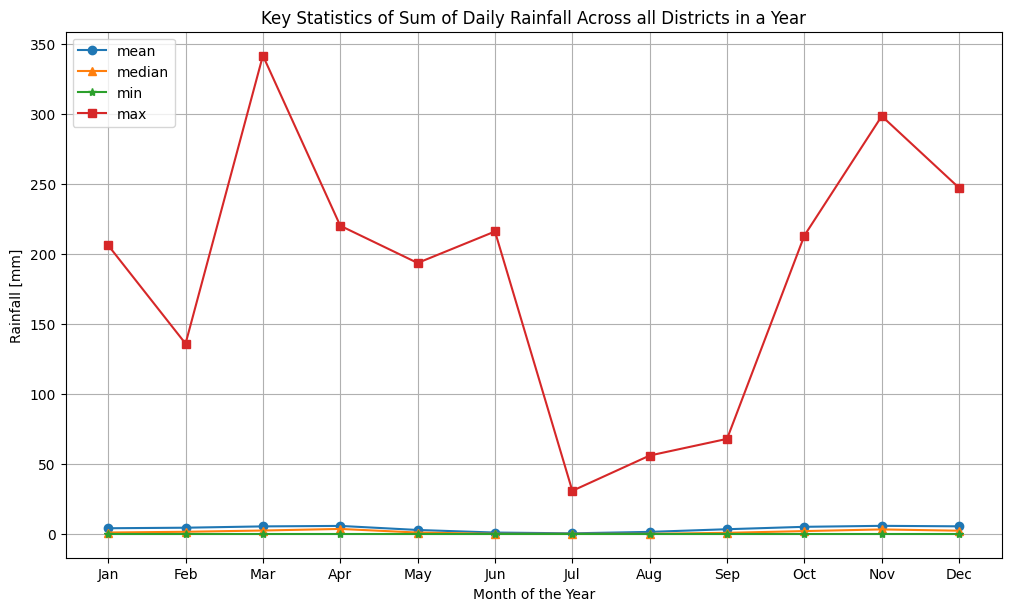

In [13]:
monthly_mean_rainfall = df_rainfall.groupby('month', observed=False).mean().mean(axis=1)
monthly_median_rainfall = df_rainfall.groupby('month', observed=False).median().median(axis=1)
monthly_min_rainfall = df_rainfall.groupby('month', observed=False).min().min(axis=1)
monthly_max_rainfall = df_rainfall.groupby('month', observed=False).max().max(axis=1)

# Plotting Rainfall Statistics
fig, axs = plt.subplots(1, 1, layout='constrained', figsize=(10, 6)) # Creating one subplot
monthly_mean_rainfall.plot(kind='line', label='mean', marker='o')
monthly_median_rainfall.plot(kind='line', label='median', marker='^')
monthly_min_rainfall.plot(kind='line', label='min', marker='*')
monthly_max_rainfall.plot(kind='line', label='max', marker='s')

axs.set_ylabel(r'Rainfall [mm]') # Setting label for vertical axis
axs.set_xlabel('Month of the Year') # Setting label for the horizontal axis
axs.set_title('Key Statistics of Sum of Daily Rainfall Across all Districts in a Year') # Specifying the title of the chart
plt.grid() # Show Grids
plt.xticks(range(0, 12), month_order, rotation=0) # label each month and force rotation to 0

plt.legend() # Show legend
plt.show() # Showing the chart

#### Investigating Trend over the past 15 years

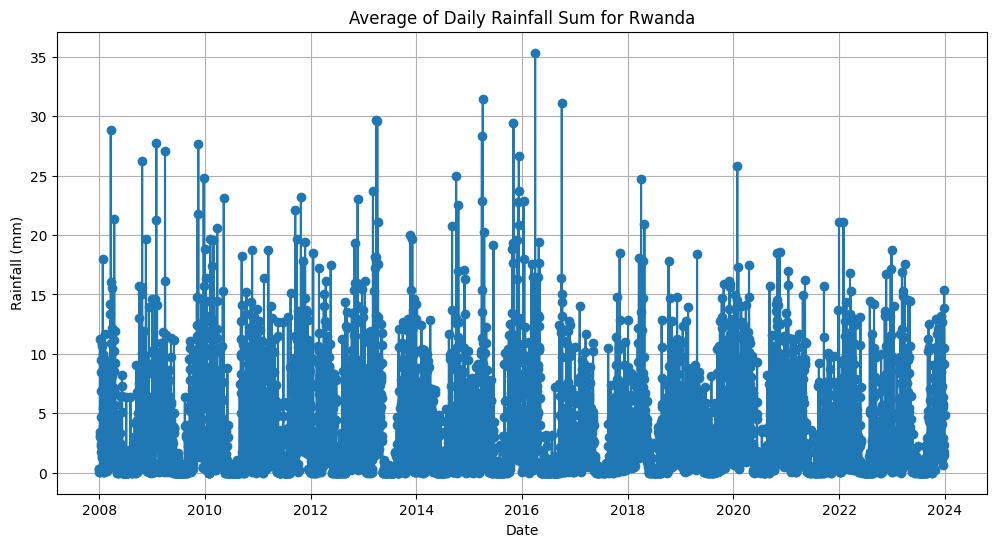

In [14]:
data = df_rainfall.loc[:, district_names]
mean_daily_rainfall_sum = data.mean(axis=1)
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_rainfall_sum.index, mean_daily_rainfall_sum, marker='o', linestyle='-')
plt.title('Average of Daily Rainfall Sum for Rwanda')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.show()

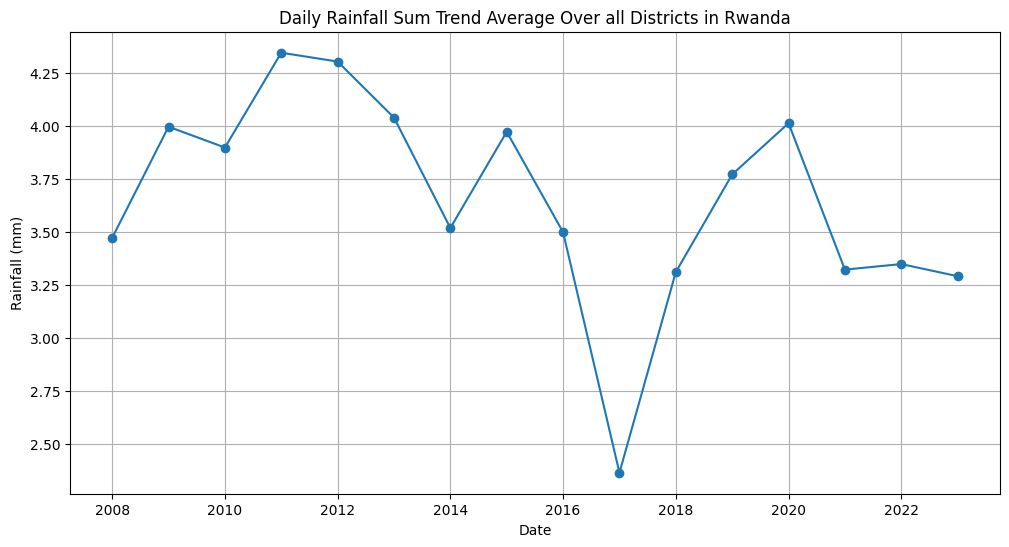

In [15]:
data = df_rainfall.loc[:, district_names]
mean_daily_rainfall_sum = pd.DataFrame(data = {
    'Rainfall_Sum': data.mean(axis=1),
    'Year': data.index.year
}, index = data.index)
yearly_rainfall = mean_daily_rainfall_sum.groupby('Year', observed=False).mean()

plt.figure(figsize=(12, 6))
plt.plot(yearly_rainfall.index, yearly_rainfall, marker='o', linestyle='-')
plt.title('Daily Rainfall Sum Trend Average Over all Districts in Rwanda')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.show()

#### Investigating trend within a year over the past 15 years

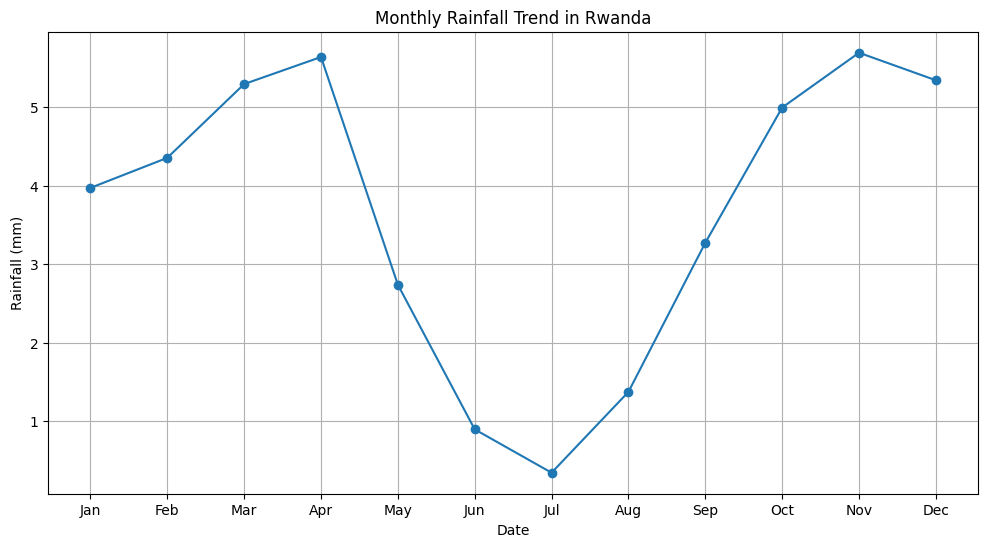

In [16]:
monthly_dataframe = df_rainfall.groupby(['month'], observed=False).mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_dataframe.index, monthly_dataframe.mean(axis=1), marker='o', linestyle='-')
plt.title('Monthly Rainfall Trend in Rwanda')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.show()

#### Autocorrelation Function 

In [17]:
data = df_rainfall.loc[:, district_names].mean(axis=1) # Aggregated rainfall data for all districts
number_of_lags = 72 # Specify the number of lags equivalent to 24 days
ACF = acf(data, nlags=number_of_lags) # Computing the ACF for 10 days lags
lags = [i for i in range(number_of_lags + 1)] # Populating Lags for the horizontal axis

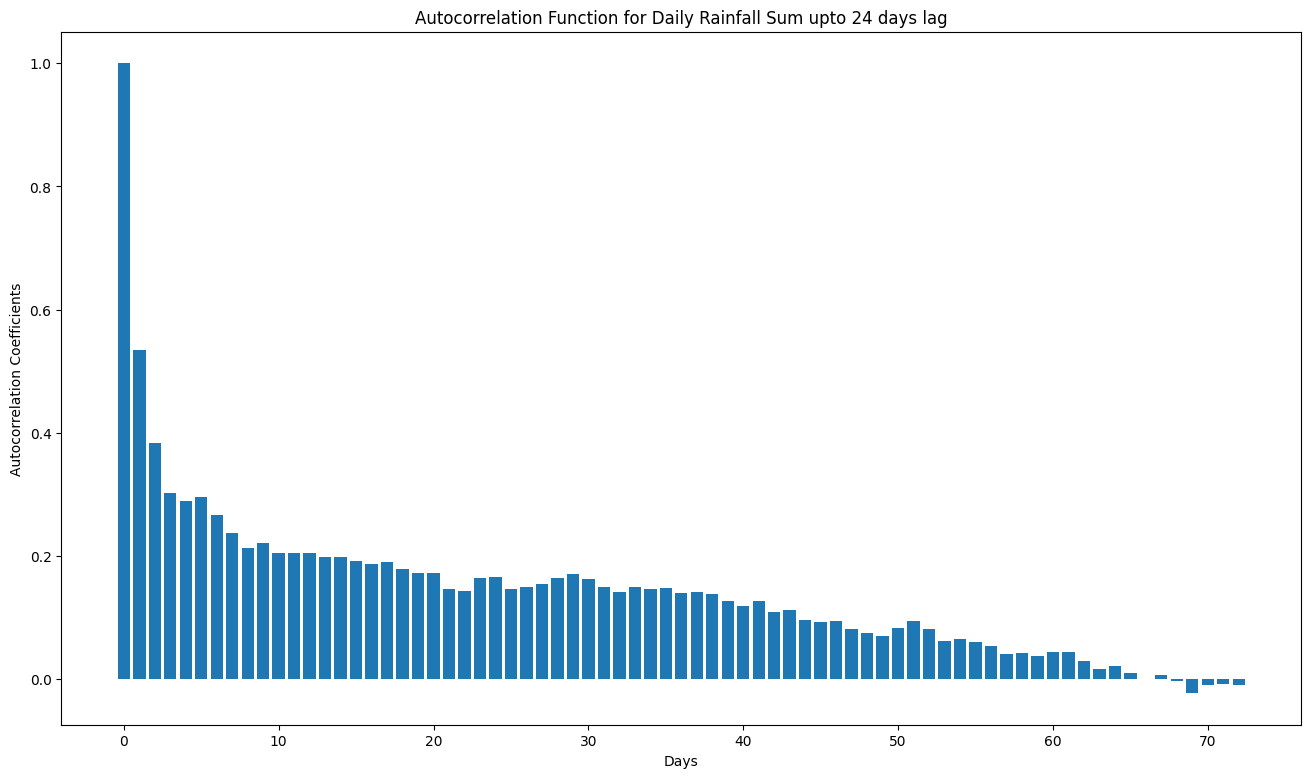

In [18]:
plt.figure(figsize=(16, 9))
plt.bar(lags, ACF)
# acf
plt.title('Autocorrelation Function for Daily Rainfall Sum upto 24 days lag')
plt.xlabel('Days') # Labeling the horizontal axis
plt.ylabel('Autocorrelation Coefficients') # Labeling the vertical axis
plt.show() # Displaying plot

#### Stationarity Test

In [19]:
data = df_rainfall.loc[:, district_names]
mean_daily_rainfall_sum = data.mean(axis=1)

def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(mean_daily_rainfall_sum)

ADF Test Statistic : -8.14129072773835
p-value : 1.0265032595062023e-12
#Lags Used : 28
Number of Observations : 5815
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


# Model Evaluation

In [20]:
# Non-Zero mean indicates presence of bias
forecast_start_date = pd.Timestamp('2024-01-01 00:00:00', tz='UTC')
forecast_end_date = pd.Timestamp('2024-04-20 00:00:00', tz='UTC')  

### Hidden Markov Chain

In [213]:
data = validation_data.loc[:, district_names]
mean_validation_daily_rainfall_sum = data.mean(axis=1)

low_threshold = 5.0
high_threshold = 20
sma_window = 12

In [292]:
season_mapping = {
    '2008': {0: ['2008-01-01', '2008-01-10'], 
             1: ['2008-01-11', '2008-06-10'], 
             2: ['2008-06-11', '2008-09-10'], 
             3: ['2008-09-11', '2008-12-31']},
    '2009': {0: ['2009-01-01', '2009-01-02'], 
             1: ['2009-01-03', '2009-06-01'], 
             2: ['2009-06-02', '2009-09-14'], 
             3: ['2009-09-15', '2009-12-31']},
    '2010': {0: None, 
             1: ['2010-01-01', '2010-06-10'], 
             2: ['2010-06-11', '2010-08-24'], 
             3: ['2010-08-25', '2010-12-31']},
    '2011': {0: None, 
             1: ['2011-01-01', '2011-05-24'], 
             2: ['2011-05-25', '2011-08-15'], 
             3: ['2011-08-16', '2011-12-31']},
    '2012': {0: ['2012-01-01', '2012-02-15'], 
             1: ['2012-02-16', '2012-06-10'], 
             2: ['2012-06-11', '2012-08-28'], 
             3: ['2012-08-29', '2012-12-31']},
    '2013': {0: None, 
             1: ['2013-01-01', '2013-05-10'], 
             2: ['2013-05-11', '2013-08-15'], 
             3: ['2013-08-16', '2013-12-31']},
    '2014': {0: None, 
             1: ['2014-01-01', '2014-05-10'], 
             2: ['2014-05-11', '2014-08-15'], 
             3: ['2014-08-16', '2014-12-31']},
    '2015': {0: ['2015-01-01', '2015-01-14'], 
             1: ['2015-01-15', '2015-06-10'], 
             2: ['2015-06-11', '2015-09-24'], 
             3: ['2015-09-25', '2015-12-31']},
    '2016': {0: None, 
             1: ['2016-01-01', '2016-05-31'], 
             2: ['2016-06-01', '2016-09-10'], 
             3: ['2016-09-11', '2016-12-31']},
    '2017': {0: ['2017-01-01', '2017-01-31'], 
             1: ['2017-02-01', '2017-05-10'], 
             2: ['2017-05-11', '2017-09-02'], 
             3: ['2017-09-03', '2017-12-31']},
    '2018': {0: None, 
             1: ['2018-01-01', '2018-05-15'], 
             2: ['2018-05-16', '2018-08-20'], 
             3: ['2018-08-21', '2018-12-31']},
    '2019': {0: None, 
             1: ['2019-01-01', '2019-06-10'], 
             2: ['2019-06-11', '2019-09-01'], 
             3: ['2019-09-02', '2019-12-31']},
    '2020': {0: None, 
             1: ['2020-01-01', '2020-05-15'], 
             2: ['2020-05-16', '2020-08-20'], 
             3: ['2020-08-21', '2020-12-31']},
    '2021': {0: None, 
             1: ['2021-01-01', '2021-05-15'], 
             2: ['2021-05-11', '2021-08-15'], 
             3: ['2021-08-16', '2021-12-31']},
    '2022': {0: None, 
             1: ['2022-01-01', '2022-06-01'], 
             2: ['2022-06-02', '2022-08-01'], 
             3: ['2022-08-02', '2022-12-31']},
    '2023': {0: ['2023-01-01', '2023-02-24'], 
             1: ['2023-02-25', '2023-05-15'], 
             2: ['2023-05-16', '2023-09-10'], 
             3: ['2023-09-11', '2023-12-31']}
}

In [367]:
labelled_data = df_rainfall.loc[:, district_names]

In [370]:
# Iterate over the keys and values of the season_mapping dictionary
for district in district_names:
    for year, season_data in season_mapping.items():
        for key, date_range in season_data.items():
            if date_range is None:
                continue
            labelled_data[district].loc[date_range[0]:date_range[1]] = key

# Display the modified DataFrame
labelled_data = labelled_data.astype(int)

#### Approach One

In [357]:
model = hmm.GaussianHMM(n_components=4, random_state=42)

# Step 3: Training the HMM
rainfall_data =  labelled_data['Gasabo'].to_numpy().reshape(-1, 1)

# Train the HMM on the rainfall data
model.fit(rainfall_data)

# Step 4: Inference
hidden_states = model.predict(rainfall_data)

In [358]:
model.startprob_ # Parameters of the Dirichlet prior distribution

array([0., 0., 0., 1.])

In [359]:
model.transmat_ #  Parameters of the Dirichlet prior distribution for each row of the transition probabilities

array([[0.99252243, 0.00498504, 0.        , 0.00249252],
       [0.        , 0.99264368, 0.00735632, 0.        ],
       [0.0106383 , 0.        , 0.9893617 , 0.        ],
       [0.        , 0.03797468, 0.        , 0.96202532]])

In [360]:
model.means_ # Mean and precision of the Normal prior distribtion

array([[3.],
       [1.],
       [2.],
       [0.]])

In [361]:
model.covars_ # Parameters of the prior distribution for the covariance matrix

array([[[4.98256104e-06]],

       [[4.59770115e-06]],

       [[6.64893617e-06]],

       [[6.32911392e-05]]])

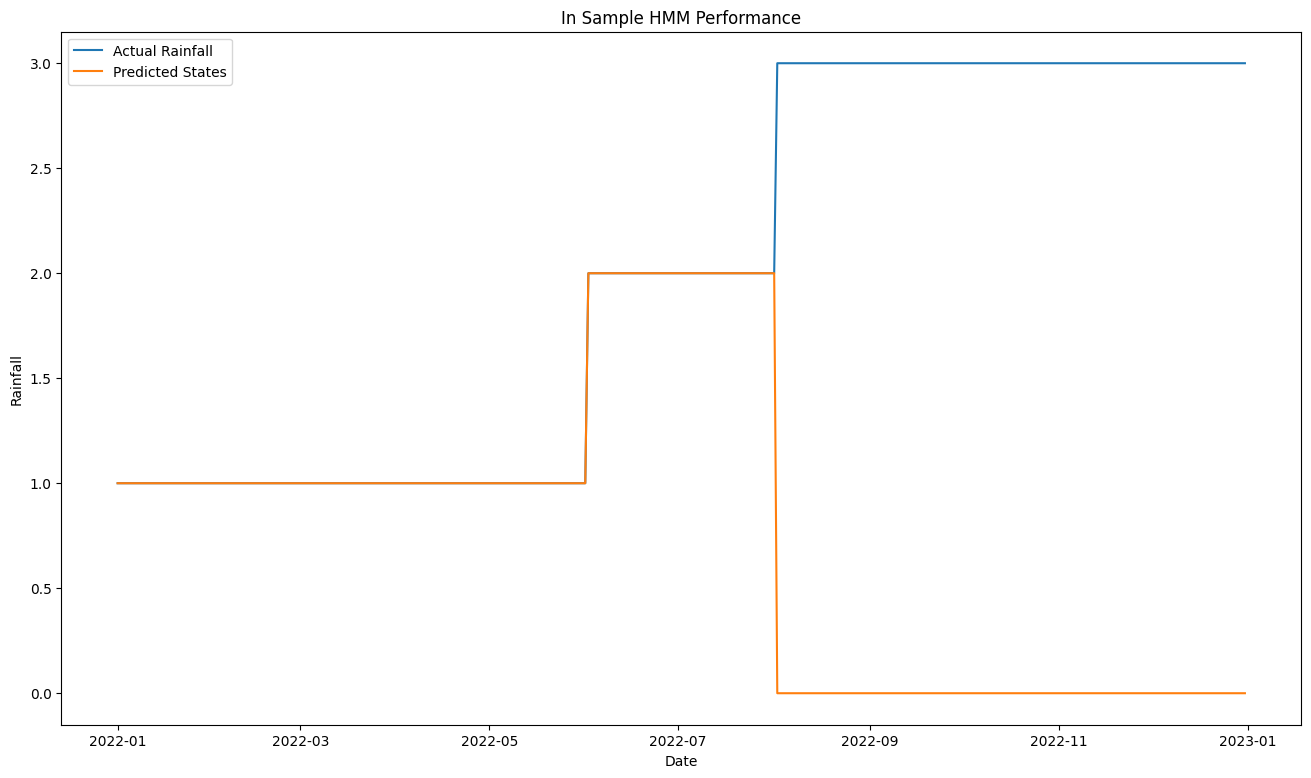

In [363]:
sma = df_rainfall['Gasabo'].rolling(window=sma_window).mean().loc['2009-01-01':'2023-12-31']

observation_data = pd.DataFrame(
    data={
        'rainfall': labelled_data['Gasabo'].to_numpy(),
        'hidden_state': hidden_states.flatten(),
    },
    index=labelled_data.index
)

subset_data = observation_data.loc['2022-01-01':'2022-12-31']

plt.figure(figsize=(16, 9))
plt.plot(subset_data.index, subset_data['rainfall'], label='Actual Rainfall')
plt.plot(subset_data.index, subset_data['hidden_state'], label='Predicted States')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.title('In Sample HMM Performance')
plt.legend()
plt.show()

In [364]:
# future_rainfall, _ = model.sample(len(validation_data))
datetime_index = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
future_rainfall, _ = model.sample(len(datetime_index))

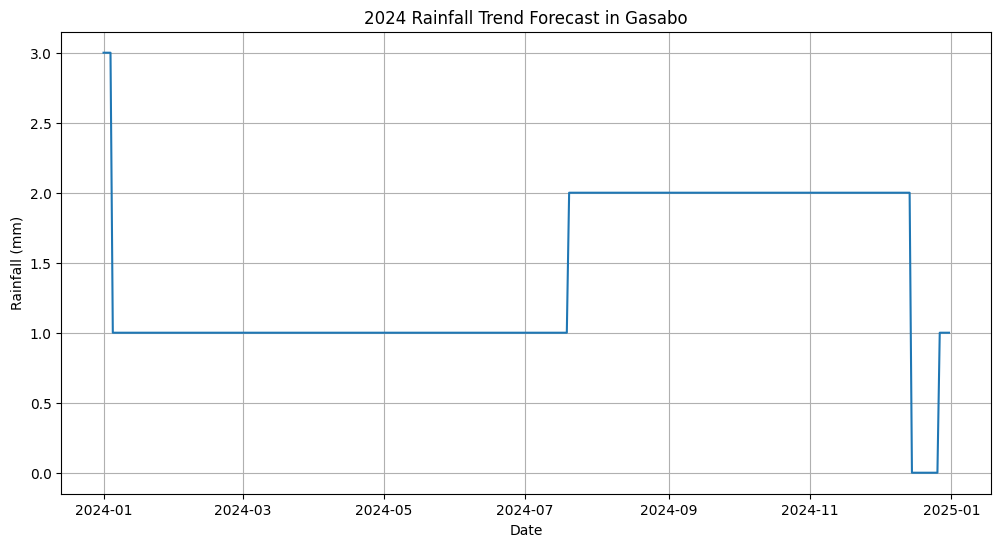

In [365]:
plt.figure(figsize=(12, 6))
plt.plot(datetime_index, model.predict(future_rainfall), linestyle='-')
plt.title('2024 Rainfall Trend Forecast in Gasabo')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.show()

In [141]:
# Saving the HMM model to file
with open("models/Rwanda.pkl", "wb") as file: 
    pickle.dump(model, file)

#### Building District Based Models

In [371]:
district_based_models = dict()

for district_name in district_names:    
    _rainfall_data = labelled_data[district_name].to_numpy().reshape(-1, 1)
    _model = hmm.GaussianHMM(n_components=4, algorithm='viterbi', n_iter=600, random_state=42, covariance_type='full')
    _model.fit(_rainfall_data)
    _model.predict(_rainfall_data)
    district_based_models[district_name] = _model
    # Saving the HMM model to file
    with open(f"models/districts/{district_name}.pkl", "wb") as file: 
        pickle.dump(_model, file)

#### Building Province Based Models

In [32]:
provinces = {
    'Eastern Province': [],
    'Southern Province': [],
    'Northern Province': [],
    'Kigali City': [],
    'Western Province': []
}

for d in districts:
    provinces[districts[d]['province']].append(d)

In [33]:
province_based_models = dict()

for province in provinces:
    data = df_rainfall.loc[:, provinces[province]]
    _rainfall_data = data.mean(axis=1).to_numpy().reshape(-1, 1)
    _model = hmm.GaussianHMM(n_components=2, algorithm='viterbi', init_params='stmc', n_iter=600, random_state=42, covariance_type='diag')
    _model.fit(_rainfall_data)
    province_based_models[province] = _model
    # Saving the HMM model to file
    with open(f"models/provinces/{province.replace(' ', '_')}.pkl", "wb") as file: 
        pickle.dump(_model, file)

In [34]:
provinces

{'Eastern Province': ['Gatsibo',
  'Rwamagana',
  'Kirehe',
  'Nyagatare',
  'Bugesera',
  'Ngoma',
  'Kayonza'],
 'Southern Province': ['Muhanga',
  'Nyaruguru',
  'Kamonyi',
  'Nyamagabe',
  'Huye',
  'Gisagara',
  'Ruhango',
  'Nyanza'],
 'Northern Province': ['Gicumbi', 'Rulindo', 'Burera', 'Gakenke', 'Musanze'],
 'Kigali City': ['Kicukiro', 'Gasabo', 'Nyarugenge'],
 'Western Province': ['Ngororero',
  'Rubavu',
  'Nyabihu',
  'Nyamasheke',
  'Karongi',
  'Rusizi',
  'Rutsiro']}

#### Approach Two

In [239]:
season_mapping = {
    '2008': {0: ['2008-01-01', '2008-01-10'], 
             1: ['2008-01-11', '2008-06-10'], 
             2: ['2008-06-11', '2008-09-10'], 
             3: ['2008-09-11', '2008-12-31']},
    '2009': {0: ['2009-01-01', '2009-01-02'], 
             1: ['2009-01-03', '2009-06-01'], 
             2: ['2009-06-02', '2009-09-14'], 
             3: ['2009-09-15', '2009-12-31']},
    '2010': {0: None, 
             1: ['2010-01-01', '2010-06-10'], 
             2: ['2010-06-11', '2010-08-24'], 
             3: ['2010-08-25', '2010-12-31']},
    '2011': {0: None, 
             1: ['2011-01-01', '2011-05-24'], 
             2: ['2011-05-25', '2011-08-15'], 
             3: ['2011-08-16', '2011-12-31']},
    '2012': {0: ['2012-01-01', '2012-02-15'], 
             1: ['2012-02-16', '2012-06-10'], 
             2: ['2012-06-11', '2012-08-28'], 
             3: ['2012-08-29', '2012-12-31']},
    '2013': {0: None, 
             1: ['2013-01-01', '2013-05-10'], 
             2: ['2013-05-11', '2013-08-15'], 
             3: ['2013-08-16', '2013-12-31']},
    '2014': {0: None, 
             1: ['2014-01-01', '2014-05-10'], 
             2: ['2014-05-11', '2014-08-15'], 
             3: ['2014-08-16', '2014-12-31']},
    '2015': {0: ['2015-01-01', '2015-01-14'], 
             1: ['2015-01-15', '2015-06-10'], 
             2: ['2015-06-11', '2015-09-24'], 
             3: ['2015-09-25', '2015-12-31']},
    '2016': {0: None, 
             1: ['2016-01-01', '2016-05-31'], 
             2: ['2016-06-01', '2016-09-10'], 
             3: ['2016-09-11', '2016-12-31']},
    '2017': {0: ['2017-01-01', '2017-01-31'], 
             1: ['2017-02-01', '2017-05-10'], 
             2: ['2017-05-11', '2017-09-02'], 
             3: ['2017-09-03', '2017-12-31']},
    '2018': {0: None, 
             1: ['2018-01-01', '2018-05-15'], 
             2: ['2018-05-16', '2018-08-20'], 
             3: ['2018-08-21', '2018-12-31']},
    '2019': {0: None, 
             1: ['2019-01-01', '2019-06-10'], 
             2: ['2019-06-11', '2019-09-01'], 
             3: ['2019-09-02', '2019-12-31']},
    '2020': {0: None, 
             1: ['2020-01-01', '2020-05-15'], 
             2: ['2020-05-16', '2020-08-20'], 
             3: ['2020-08-21', '2020-12-31']},
    '2021': {0: None, 
             1: ['2021-01-01', '2021-05-15'], 
             2: ['2021-05-11', '2021-08-15'], 
             3: ['2021-08-16', '2021-12-31']},
    '2022': {0: None, 
             1: ['2022-01-01', '2022-06-01'], 
             2: ['2022-06-02', '2022-08-01'], 
             3: ['2022-08-02', '2022-12-31']},
    '2023': {0: ['2023-01-01', '2023-02-24'], 
             1: ['2023-02-25', '2023-05-15'], 
             2: ['2023-05-16', '2023-09-10'], 
             3: ['2023-09-11', '2023-12-31']}
}

In [248]:
labelled_data = df_rainfall['Gasabo']
# Iterate over the keys and values of the season_mapping dictionary
for year, season_data in season_mapping.items():
    for key, date_range in season_data.items():
        if date_range is None:
            continue
        labelled_data.loc[date_range[0]:date_range[1]] = 0 if key == 2 else 1

# Display the modified DataFrame
labelled_data = labelled_data.astype(int)
print(labelled_data)

Unnamed: 0
2008-01-01 00:00:00+00:00    1
2008-01-02 00:00:00+00:00    1
2008-01-03 00:00:00+00:00    1
2008-01-04 00:00:00+00:00    1
2008-01-05 00:00:00+00:00    1
                            ..
2023-12-27 00:00:00+00:00    1
2023-12-28 00:00:00+00:00    1
2023-12-29 00:00:00+00:00    1
2023-12-30 00:00:00+00:00    1
2023-12-31 00:00:00+00:00    1
Name: Gasabo, Length: 5844, dtype: int32


C:\Users\robot\AppData\Local\Temp\ipykernel_11944\2833208272.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data.loc[date_range[0]:date_range[1]] = 0 if key == 2 else 1


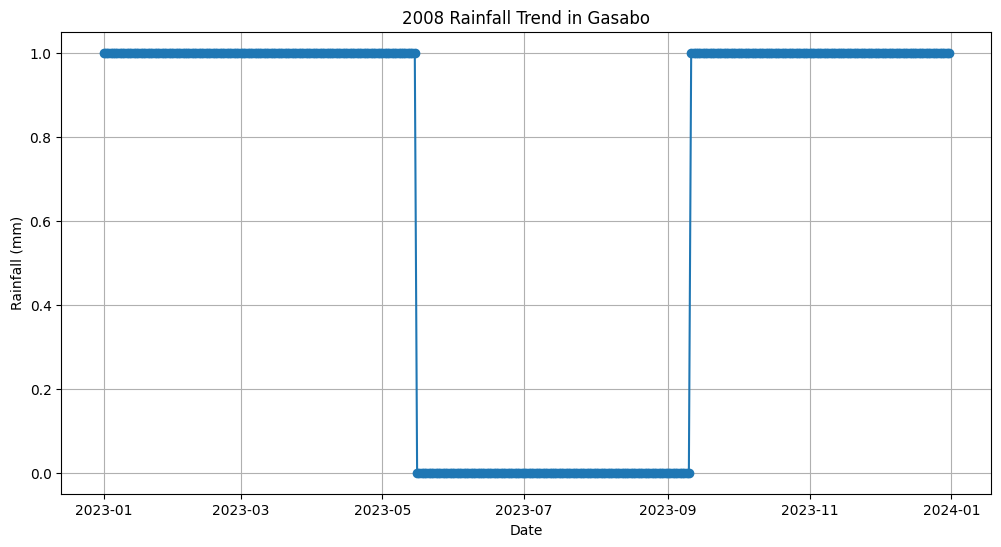

In [249]:
gasabo_data = labelled_data.loc['2023-01-01':'2023-12-31']
plt.figure(figsize=(12, 6))
plt.plot(gasabo_data.index, gasabo_data, marker='o', linestyle='-')
plt.title('2008 Rainfall Trend in Gasabo')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.show()

#### Approach Three

In [250]:
params = ['wet', 'dry']
number_of_params = len(params)
observation_states = ['dry', 'wet']
number_of_observation_states = len(observation_states)
params_probability = np.array([0.6, 0.4])
transition_probability = np.array([[0.85, 0.15], [0.15, 0.85]])
emission_probability = np.array([[0.5, 0.5], [0.5, 0.5]])

In [251]:
hidden_markov_model = hmm.CategoricalHMM(n_components = 2)
hidden_markov_model.fit(labelled_data.to_numpy().reshape(-1, 1))

CategoricalHMM(n_components=2, n_features=2,
               random_state=RandomState(MT19937) at 0x2357589ED40)

In [264]:
# hidden_markov_model_fitted = hidden_markov_model.fit(observation_sequence)
hidden_states = hidden_markov_model.predict(labelled_data.to_numpy().reshape(-1, 1))

In [265]:
# Forecast future rainfall intensity levels
forecast_states, _ = hidden_markov_model.sample(n_samples=len(mean_validation_daily_rainfall_sum))

In [254]:
# Viterbi
log_probability, forecast_hidden_states = hidden_markov_model.decode(
    forecast_states,
    lengths=len(forecast_states),
    algorithm='viterbi'
)

In [255]:
# Viterbi
log_probability, hidden_states = hidden_markov_model.decode(
    observation_sequence,
    lengths=len(observation_sequence),
    algorithm='viterbi'
)

In [261]:
observation_data = pd.DataFrame(
    data={
        'rainfall': df_rainfall['Gasabo'],
        'hidden_state': hidden_states
    },
    index=df_rainfall['Gasabo'].index
)

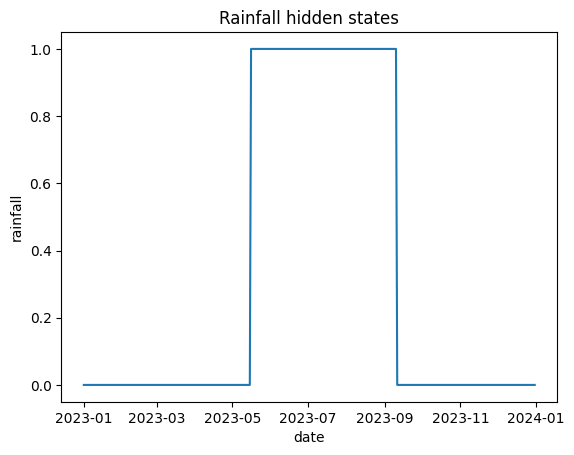

In [263]:
subset_data = observation_data.loc['2023-01-01':'2023-12-31']

# plt.plot(subset_data.index, subset_data['rainfall'], label='rainfall')
plt.plot(subset_data.index, subset_data['hidden_state'], label='hidden state')
plt.xlabel('date')
plt.ylabel('rainfall')
plt.title('Rainfall hidden states')
plt.show()

In [ ]:
sb.set_style('darkgrid')
plt.plot(hidden_states, '-o', label='hiddent states')
plt.xlabel('time steps')
plt.ylabel('most likely hidden states')
plt.title('Dry or Wet Season')
plt.show()

In [ ]:
# Model Evaluation
data = validation_data.loc[:, district_names]
mean_validation_daily_rainfall_sum = data.mean(axis=1)
plt.figure(figsize=(12, 6))
plt.plot(mean_validation_daily_rainfall_sum.index, mean_validation_daily_rainfall_sum, label='Actual')
plt.plot(mean_validation_daily_rainfall_sum.index, forecast_hidden_states, label='Hidden States')

plt.title('Evaluation of Forecast with Actual Rainfall Data')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.legend()
plt.show()